<h4>Assignment xgboost </h4>

<h4>Import Libraries</h4>

In [2]:
import os 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.preprocessing         import StandardScaler
from sklearn.datasets              import load_digits
from sklearn.metrics               import confusion_matrix, f1_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection       import train_test_split, RandomizedSearchCV

<h5>Basic Parameters for Housekeeing</h5>

In [4]:
# define and set random state 
RANDOM_STATE = 24
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results

# parameters for Matplotlib
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 7),
          'axes.labelsize': 'large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'large',
          'savefig.dpi': 75,
          'image.interpolation': 'none',
          'savefig.bbox' : 'tight',
          'lines.linewidth' : 1,
          'legend.numpoints' : 1,
          'scatter.edgecolors': 'b' # edge color of markers
         }

CMAP = plt.cm.rainbow
plt.rcParams.update(params)
plt.set_cmap(CMAP)

plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

TEST_SIZE = 0.2

<Figure size 1500x700 with 0 Axes>

<h4>Digits Dataset</h4>

In [6]:
digits = load_digits()

digits.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [7]:
#split the data

X_train, X_test, y_train, y_test = train_test_split(digits.data,
                                                    digits.target,
                                                    stratify = digits.target,
                                                    test_size = TEST_SIZE, random_state = RANDOM_STATE)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1437, 64), (360, 64), (1437,), (360,))

In [8]:
print(X_train.mean(), X_train.max(), X_train.min(), X_test.mean(), X_test.max(), X_test.min())

4.883350730688935 16.0 0.0 4.887413194444444 16.0 0.0


In [9]:
scaler = StandardScaler()

scaler.fit(X_train) # alwyas fit on train data

X_train = scaler.transform(X_train)

X_test = scaler.transform(X_test)


In [10]:
print(X_train.mean(), X_train.max(), X_train.min(), X_test.mean(), X_test.max(), X_test.min())

-6.953380112474884e-18 37.89459064299318 -2.9957679411411133 -0.0012848969409853287 15.44704883417374 -2.9957679411411133


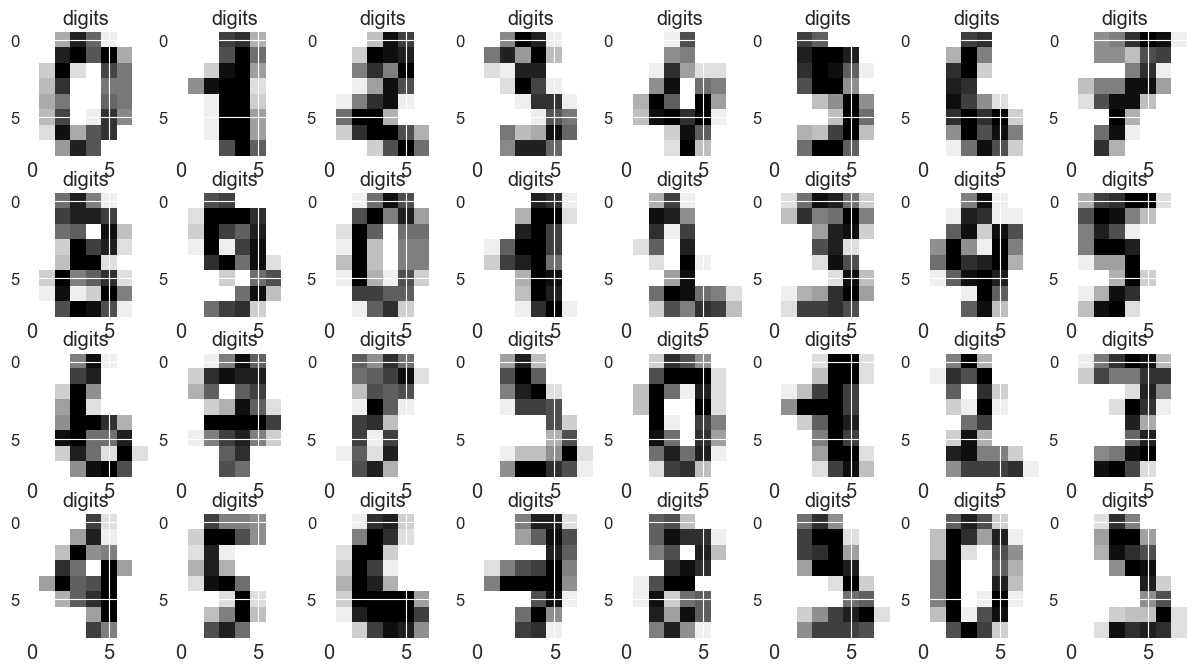

In [11]:
fig , axes = plt.subplots(4,8 , figsize= (15,8))

axes = axes.ravel()
for i in range(32):
    ax= axes[i]
    ax.imshow(digits.images[i], cmap =plt.cm.binary)
    ax.set_title('digits')


In [12]:
clf = xgb.XGBClassifier(tree_method = 'hist', 
                        random_state = RANDOM_STATE, 
                        n_jobs = 16 )
clf

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=16,
              num_parallel_tree=None, random_state=24, ...)

In [13]:
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

acc= accuracy_score(y_test, y_pred)

acc

0.9666666666666667

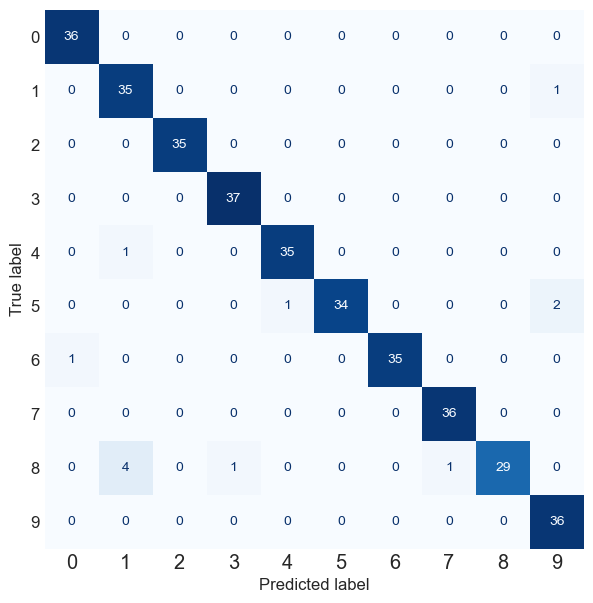

In [14]:
cm = confusion_matrix(y_true = y_test, y_pred=y_pred)
disp= ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=digits.target_names)
disp.plot(cmap= plt.cm.Blues, colorbar=False)
plt.grid(False)
plt.show()

<h4>Randomized Grid Search</h4>

In [16]:
params = {
    'n_estimators'       : [100, 500, 1000],  #number of weak Trees
    'max_depth'          : [3, 8, 10, 20, 50], #max_depth, we saw 10 was best
    'learning_rate'      : [0.01, 0.1, 0.2, 0.3],
    'subsample'          : np.arange(0.5, 1.0, 0.1), 
    'colsample_bytree'  : np.arange(0.4, 1.0, 0.1),
    'colsample_bylevel' : np.arange(0.4, 1.0, 0.1)
   
    
}

xgc = xgb.XGBClassifier(tree_method = 'hist', 
                        random_state = RANDOM_STATE, 
                        n_jobs = 16,
                        verbosity=1)

clf = RandomizedSearchCV(estimator=xgc, 
                         param_distributions=params, 
                         scoring='accuracy', 
                         n_iter=10, 
                         verbose=1)

clf.fit(X_train, y_train)
print(clf.best_params_)
print(clf.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'subsample': 0.7999999999999999, 'n_estimators': 500, 'max_depth': 20, 'learning_rate': 0.2, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.7}
0.9756533101045296


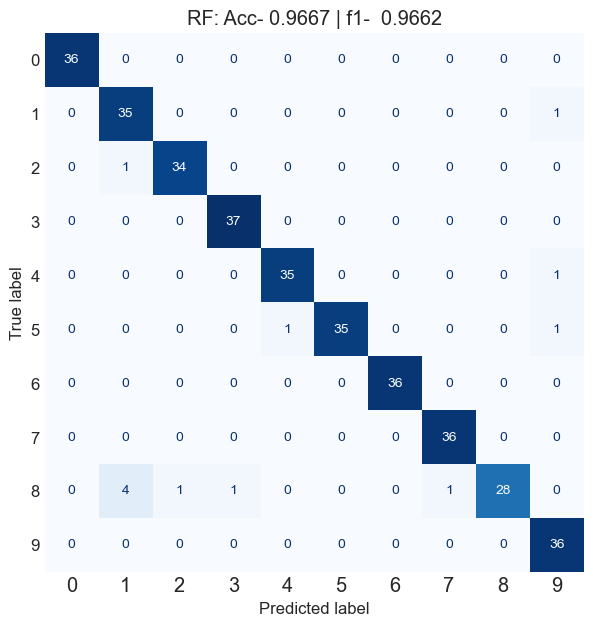

In [17]:
y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)

f1score= f1_score(y_true=y_test,  y_pred=y_pred, average='weighted')

cm= confusion_matrix(y_true=y_test, y_pred=y_pred)

disp= ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=digits.target_names)

disp.plot(cmap= plt.cm.Blues, colorbar=False)

plt.title(f'RF: Acc- {acc:0.4f} | f1- {f1score: 0.4f}')
plt.grid(False)
plt.show()
